# 07 Baseline Models – Citi Bike 
# 
# **Purpose**  Benchmark naive lag forecasting models on hourly Citi Bike demand so we have a sanity‑check before tuning LightGBM.
#


In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project imports


In [24]:
import pandas as pd
import numpy as np
import mlflow
from sklearn.metrics import mean_absolute_error
from datetime import datetime

# Optional: Auto-start local MLflow server
# !mlflow ui --port 5000


In [25]:

# Local imports – ensure project root is on PYTHONPATH
sys.path.append(str(Path().resolve().parent))

from src.config import TRANSFORMED_DATA_DIR
from src.data_utils import split_time_series_data
from src.models.baseline import LastHourBaseline, LastDayBaseline, LastWeekBaseline
from src.plot_utils import plot_aggregated_time_series
from src.utils.mlflow_logging import set_mlflow_tracking, log_model_to_mlflow


## Load features

In [27]:
df = pd.read_parquet("../data/processed/2023/citibike_hourly_features_top3.parquet")
print(df.shape)
df.head()


(26280, 19)


,start_station_id,start_hour,rides,hour,dow,doy,sin_hour,cos_hour,sin_dow,cos_dow,is_weekend,is_holiday,lag_1,lag_24,lag_168,lag_672,rollmean_24,rollmean_168,target_t_plus_1
0,5329.03,2023-01-01 00:00:00,1,0,6,1,0.000000,1.000000,-0.781831,0.62349,1,0,NaN,NaN,NaN,NaN,1.000000,1.000000,1.0
1,5329.03,2023-01-01 01:00:00,1,1,6,1,0.258819,0.965926,-0.781831,0.62349,1,0,1.0,NaN,NaN,NaN,1.000000,1.000000,0.0
2,5329.03,2023-01-01 02:00:00,0,2,6,1,0.500000,0.866025,-0.781831,0.62349,1,0,1.0,NaN,NaN,NaN,0.666667,0.666667,0.0
3,5329.03,2023-01-01 03:00:00,0,3,6,1,0.707107,0.707107,-0.781831,0.62349,1,0,0.0,NaN,NaN,NaN,0.500000,0.500000,1.0
4,5329.03,2023-01-01 04:00:00,1,4,6,1,0.866025,0.500000,-0.781831,0.62349,1,0,0.0,NaN,NaN,NaN,0.600000,0.600000,0.0


## Train test split

In [28]:
df['start_hour'] = pd.to_datetime(df['start_hour'])  # if not already parsed
cutoff_date = datetime(2023, 11, 1)

train_df = df[df['start_hour'] < cutoff_date].copy()
test_df  = df[df['start_hour'] >= cutoff_date].copy()


## Naive Lag Prediction dataframes

In [30]:
y_train = train_df['target_t_plus_1']
y_test  = test_df['target_t_plus_1']

y_pred_train = train_df['lag_1']
y_pred_test  = test_df['lag_1']


# drop NaN rows

In [32]:
# Ensure no NaNs in evaluation columns
train_eval = train_df[["lag_1", "target_t_plus_1"]].dropna()
test_eval  = test_df[["lag_1", "target_t_plus_1"]].dropna()

# Extract cleaned series
y_train = train_eval["target_t_plus_1"]
y_pred_train = train_eval["lag_1"]

y_test = test_eval["target_t_plus_1"]
y_pred_test = test_eval["lag_1"]

# Now evaluate
from sklearn.metrics import mean_absolute_error
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")


Train MAE: 8.63
Test MAE: 6.75


# Log in MLFlow

In [44]:
import os
from dotenv import load_dotenv
import mlflow

# Load secrets from .env
load_dotenv()

True

In [45]:

# Set MLflow tracking config
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))

os.environ["MLFLOW_TRACKING_USERNAME"] = os.getenv("MLFLOW_TRACKING_USERNAME")
os.environ["MLFLOW_TRACKING_PASSWORD"] = os.getenv("MLFLOW_TRACKING_PASSWORD")



In [48]:
mlflow.set_experiment("citibike_baseline_model")


2025/05/10 05:47:55 INFO mlflow.tracking.fluent: Experiment with name 'citibike_baseline_model' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/d9fe5244c8af4dd1878de125d70b0a81', creation_time=1746870475279, experiment_id='0', last_update_time=1746870475279, lifecycle_stage='active', name='citibike_baseline_model', tags={}>

In [49]:

# Optional: confirm everything is loading
print("Tracking URI:", mlflow.get_tracking_uri())
print("Experiment:", mlflow.get_experiment_by_name("citibike_baseline_model"))


Tracking URI: https://dagshub.com/Vr1155/citibike.mlflow
Experiment: <Experiment: artifact_location='mlflow-artifacts:/d9fe5244c8af4dd1878de125d70b0a81', creation_time=1746870475279, experiment_id='0', last_update_time=1746870475279, lifecycle_stage='active', name='citibike_baseline_model', tags={}>


In [50]:

with mlflow.start_run(run_name="naive_lag_baseline") as run:
    mlflow.log_param("model_type", "naive_lag")
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)

    tracking_url = mlflow.get_tracking_uri()
    experiment_id = run.info.experiment_id
    run_id = run.info.run_id

    print(" View Run at:")
    print(f"{tracking_url}/#/experiments/{experiment_id}/runs/{run_id}")

 View Run at:
https://dagshub.com/Vr1155/citibike.mlflow/#/experiments/0/runs/3e00060952884f728b8edacb172fd5a5
🏃 View run naive_lag_baseline at: https://dagshub.com/Vr1155/citibike.mlflow/#/experiments/0/runs/3e00060952884f728b8edacb172fd5a5
🧪 View experiment at: https://dagshub.com/Vr1155/citibike.mlflow/#/experiments/0


# Plot

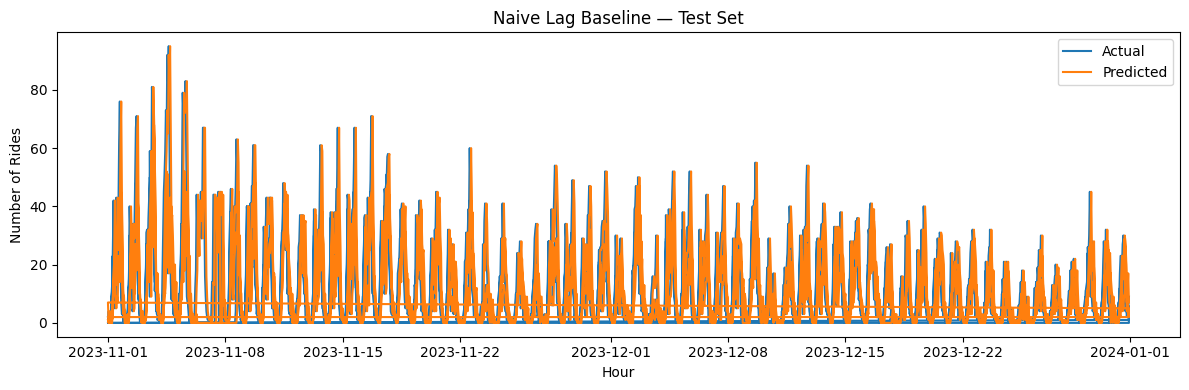

In [52]:
test_eval = test_df[["start_hour", "lag_1", "target_t_plus_1"]].dropna()



# Use the test_eval DataFrame, which already has dropped NaNs
plt.figure(figsize=(12, 4))
plt.plot(test_eval['start_hour'], y_test.values, label='Actual')
plt.plot(test_eval['start_hour'], y_pred_test.values, label='Predicted')
plt.title("Naive Lag Baseline — Test Set")
plt.xlabel("Hour")
plt.ylabel("Number of Rides")
plt.legend()
plt.tight_layout()
plt.show()
